In [ ]:
# Basic Libraries
import os
import pandas as pd
import numpy as np

# Libraries for Preprocessing
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Libraries for Model-Building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
# Evaluation Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [ ]:
data=pd.read_csv('train_F3fUq2S.csv')

data.head()
cat=['sender','day_of_week','times_of_day','category','product','target_audience']
data[cat]=data[cat].astype('str')
data.dtypes
data.head()

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,...,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,1,3,76,10439,39,5,1,Noon,6,26,...,0,0,0,0,0,0,0,0,14,0.103079
1,2,3,54,2570,256,5,1,Morning,2,11,...,0,0,0,0,0,0,0,0,10,0.700000
2,3,3,59,12801,16,5,1,Noon,2,11,...,1,0,1,0,0,0,0,0,16,0.002769
3,4,3,74,11037,30,4,0,Evening,15,9,...,0,0,0,0,0,0,0,0,10,0.010868
4,5,3,80,10011,27,5,1,Noon,6,26,...,0,0,1,0,0,0,0,0,14,0.142826


In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


@interact(feature=data.columns.to_list())
def describe_features(feature):
    print ("Number of unique values in {} column are {} \n The unique values are {}".format(feature, len(data[feature].unique()),data[feature].unique()))

interactive(children=(Dropdown(description='feature', options=('campaign_id', 'sender', 'subject_len', 'body_l…

In [ ]:
def cap_outliers(series, iqr_threshold=1.5, verbose=False):
    '''Caps outliers to closest existing value within threshold (IQR).
    Args: Series, iqr threshold, verbose
    Return: Capped series'''
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lbound = Q1 - iqr_threshold * IQR
    ubound = Q3 + iqr_threshold * IQR

    outliers = (series < lbound) | (series > ubound)

    series = series.copy()
    series.loc[series < lbound] = series.loc[~outliers].min()
    series.loc[series > ubound] = series.loc[~outliers].max()

    # For comparison purposes.
    if verbose:
            print('\n'.join(
                ['Capping outliers by the IQR method:',
                 f'   IQR threshold: {iqr_threshold}',
                 f'   Lower bound: {lbound}',
                 f'   Upper bound: {ubound}\n']))
    return series

In [ ]:
data['subject_len'] = cap_outliers(data['subject_len'],iqr_threshold=1.5)
data['mean_paragraph_len'] = cap_outliers(data['mean_paragraph_len'],iqr_threshold=1.5)
data['body_len'] = cap_outliers(data['body_len'],iqr_threshold=1)

In [ ]:
label_encoder = preprocessing.LabelEncoder()
data['times_of_day']=label_encoder.fit_transform(data['times_of_day'])


In [ ]:
y=data["click_rate"]
X=data.drop(['click_rate','campaign_id','is_timer'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=123)
X_train.head()
X_train=X_train.drop(['is_discount','is_price','is_urgency','is_emoticons','sender','is_weekend','is_personalised'],axis=1)
X_test=X_test.drop(['is_discount','is_price','is_urgency','is_emoticons','sender','is_weekend','is_personalised'],axis=1)

In [ ]:
X=X.drop(['is_discount','is_price','is_urgency','is_emoticons','sender','is_weekend','is_personalised'],axis=1)

In [ ]:
from sklearn.model_selection import cross_val_score,KFold
def model_perf(mdl,X_train,X_test,y_train,y_test):
    kf=KFold(n_splits=5,random_state=1020,shuffle=True)
    ypred_tes=mdl.predict(X_test)
    ypred_trn=mdl.predict(X_train)
    cv=cross_val_score(mdl,X_train,y_train,cv=kf,scoring='r2')
#     print('Training score:',mdl.score(xtrain,ytrain))
#     print('Testing score:',mdl.score(xtest,ytest))
    print('='*50)
    print('Training r2:',r2_score(y_train,ypred_trn))
    print('Testing r2:',r2_score(y_test,ypred_tes))
    print('='*50)
    print('Train RMSE',np.sqrt(mean_squared_error(y_train,ypred_trn)))
    print('Test RMSE',np.sqrt(mean_squared_error(y_test,ypred_tes)))
    print('='*50)
    print('cross-val average:',np.mean(cv))
    print('cross-val variance:',np.std(cv)/np.mean(cv))

In [ ]:
from sklearn.pipeline import Pipeline
params = {'n_estimators': 400,
          'max_depth':10
          }
from sklearn.preprocessing import PowerTransformer
pipe=Pipeline((
('pt',PowerTransformer()),
 ('lr',RandomForestRegressor(**params)),
))
pipe.fit(X_train,y_train)
from sklearn.metrics import mean_squared_error,r2_score
model_perf(pipe,X_train,X_test,y_train,y_test)

Training r2: 0.8950447956227852
Testing r2: 0.639619876559363
Train RMSE 0.026780627224282195
Test RMSE 0.054040305162573056
cross-val average: 0.4039565115315501
cross-val variance: 0.16727121099819917


In [24]:
test=pd.read_csv('test_Bk2wfZ3.csv')
test1=pd.read_csv('test_Bk2wfZ3.csv')
test=test.drop(['campaign_id','is_timer'],axis=1)
test['subject_len'] = cap_outliers(test['subject_len'],iqr_threshold=1.5)
test['mean_paragraph_len'] = cap_outliers(test['mean_paragraph_len'],iqr_threshold=1)
test['body_len'] = cap_outliers(test['body_len'],iqr_threshold=1)
test['times_of_day']=label_encoder.fit_transform(test['times_of_day'])
test[cat]=test[cat].astype('category')
test=test.drop(['is_discount','is_price','is_urgency','is_emoticons','sender','is_weekend','is_personalised'],axis=1)
print(test.columns)
ra=pipe.predict(test)
ra1=pipe1.predict(test)
r=ra-ra1
finalRA=pd.DataFrame([test1['campaign_id'],r])
finalRA=finalRA.T
finalRA.columns=['campaign_id','click_rate']
finalRA.to_csv('subN0.csv')

Index(['subject_len', 'body_len', 'mean_paragraph_len', 'day_of_week',
       'times_of_day', 'category', 'product', 'no_of_CTA', 'mean_CTA_len',
       'is_image', 'is_quote', 'target_audience'],
      dtype='object')


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
pipe=Pipeline((
('pt',PowerTransformer()),
 ('lr',KNeighborsRegressor(n_neighbors=2)),
))
pipe.fit(X_train,y_train)
from sklearn.metrics import mean_squared_error,r2_score
model_perf(pipe,X_train,X_test,y_train,y_test)

Training r2: 0.7850304677885388
Testing r2: 0.5068121152381295
Train RMSE 0.03832721039093799
Test RMSE 0.06321841130564088
cross-val average: 0.12337449219963421
cross-val variance: 1.504677437657658


In [ ]:
from sklearn.svm import SVR
pipe=Pipeline((
('pt',PowerTransformer()),
 ('lr',SVR())
))
pipe.fit(X_train,y_train)
from sklearn.metrics import mean_squared_error,r2_score
model_perf(pipe,X_train,X_test,y_train,y_test)

Training r2: 0.38638969568427517
Testing r2: 0.3208245509576454
Train RMSE 0.06475377278597597
Test RMSE 0.07418709530847176
cross-val average: 0.019602493850333212
cross-val variance: 12.13851873410718


In [ ]:
import xgboost as xgb
pipe=Pipeline((
('pt',PowerTransformer()),
 ('lr',xgb.XGBRegressor(max_depth=4))
))
pipe.fit(X_train,y_train)
from sklearn.metrics import mean_squared_error,r2_score
model_perf(pipe,X_train,X_test,y_train,y_test)

[13:07:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:07:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training r2: 0.8152749617603294
Testing r2: 0.5466707913113026
Train RMSE 0.035528889850271556
Test RMSE 0.060609992329484476
cross-val average: 0.3716411042986544
cross-val variance: 0.21433670947093672


In [12]:
ypred=pipe.predict(X)

In [13]:
X['initialest']=ypred

In [14]:
X['error']=y-X['initialest']

In [22]:

Xt=X.drop(['initialest','error'],axis=1)
yt=X['error'].values

In [23]:
from sklearn.pipeline import Pipeline
params = {'n_estimators': 500,
          'max_depth':12
          }
from sklearn.preprocessing import PowerTransformer
pipe1=Pipeline((
('pt',PowerTransformer()),
 ('lr',RandomForestRegressor()),
))
pipe1.fit(Xt,yt)




Pipeline(steps=[('pt', PowerTransformer()), ('lr', RandomForestRegressor())])

In [ ]:
clf1 = LinearRegression()
clf2= DecisionTreeRegressor()
clf3=  RandomForestRegressor()
#clf4 = KNeighborsRegressor(n_neighbors=5) 
#clf5= GaussianNB()
clf4=XGBRegressor()
clf5=GradientBoostingRegressor()
clf6=AdaBoostRegressor()

In [ ]:
for i,j in zip([clf1,clf2,clf3,clf4,clf5,clf6],['LR','DT','RF','XGB','GBD','ADB']):
    kf=KFold(n_splits=10,random_state=1020,shuffle=True)
    score = cross_val_score(i, X_train, y_train, cv=kf, scoring='r2')
    print(j,np.mean(score),np.std(score)/np.mean(score))

LR 0.12354732473781183 0.5033697986281659
DT -0.339530737869573 -1.3857751589208422
RF 0.4381091224129497 0.2088149447563122
XGB nan nan
GBD 0.39026001064336446 0.25547614236476357
ADB -0.39518948050694747 -1.2342347713279522


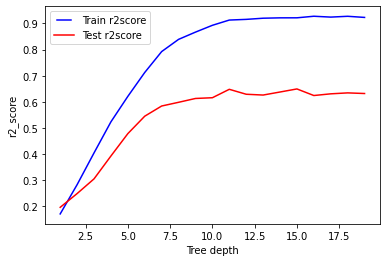

In [ ]:
max_depths = range(1,20)

train_results = []
test_results = []

for max_depth in max_depths:
    pipe=Pipeline((
    ('pt',PowerTransformer()),
    ('lr',RandomForestRegressor(max_depth=max_depth)),
    ))
    pipe.fit(X_train,y_train)

    train_pred = pipe.predict(X_train)
    r2_score_train=r2_score(y_train,train_pred)
    train_results.append(r2_score_train)

    test_pred = pipe.predict(X_test)
    r2_score_test=r2_score(y_test,test_pred)
    test_results.append(r2_score_test)
    
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results,'b', label='Train r2score')
line2, = plt.plot(max_depths, test_results,'r', label='Test r2score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('r2_score')
plt.xlabel('Tree depth')
plt.show()


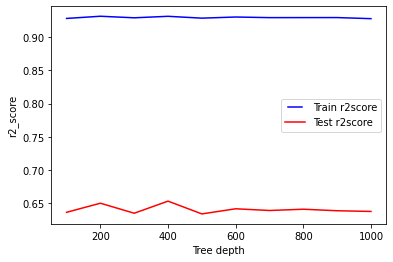

In [ ]:
n = [100,200,300,400,500,600,700,800,900,1000]

train_results = []
test_results = []

for i in n:
    pipe=Pipeline((
    ('pt',PowerTransformer()),
    ('lr',RandomForestRegressor(n_estimators=i)),
    ))
    pipe.fit(X_train,y_train)

    train_pred = pipe.predict(X_train)
    r2_score_train=r2_score(y_train,train_pred)
    train_results.append(r2_score_train)

    test_pred = pipe.predict(X_test)
    r2_score_test=r2_score(y_test,test_pred)
    test_results.append(r2_score_test)
    
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n, train_results,'b', label='Train r2score')
line2, = plt.plot(n, test_results,'r', label='Test r2score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('r2_score')
plt.xlabel('Tree depth')
plt.show()

[13:04:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:04:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:04:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:04:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:04:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:04:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:04:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:04:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

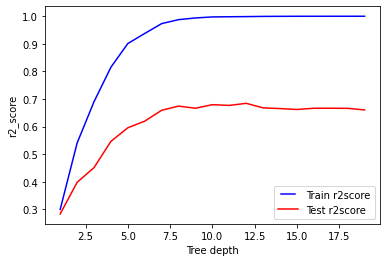

In [ ]:
max_depths = range(1,20)
import xgboost as xgb
train_results = []
test_results = []

for max_depth in max_depths:
    pipe=Pipeline((
    ('pt',PowerTransformer()),
    ('lr',xgb.XGBRegressor(max_depth=max_depth)),
    ))
    pipe.fit(X_train,y_train)

    train_pred = pipe.predict(X_train)
    r2_score_train=r2_score(y_train,train_pred)
    train_results.append(r2_score_train)

    test_pred = pipe.predict(X_test)
    r2_score_test=r2_score(y_test,test_pred)
    test_results.append(r2_score_test)
    
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results,'b', label='Train r2score')
line2, = plt.plot(max_depths, test_results,'r', label='Test r2score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('r2_score')
plt.xlabel('Tree depth')
plt.show()